# Time Series

We often deal with time series data: data which come from units of interest that are repeatedly measured over time. We have have time series data whenever we do outcome monitoring, for example. Government agencies produce time serieses: they release information at regular intervals described some relevant characteristic of a country or state. As we discussed in class and covered in readings, we need to deal with the statistical issues derived from the data generating process of repeatedly measuring the same unit (or units if we have panel or TSCS, or pCSTS data).

In this activity, we will cover the basics of analyzing time series data in R using data on the U.S. economy and data from the OECD. First, we'll examine the relationship between the [Univeristy of Michigan's Consumer Sentiment data series](https://fred.stlouisfed.org/series/UMCSENT), made avaialable by the FRED^[I used the `fredr` package to download the data. It does require registering with the FRED to receive an API key.].

There are a number of packages we'll use to analyze time series data. Install them (only if you have not already done so), and load them.

In [1]:

#install.packages("tseries")
#install.packages("dynlm")
#install.packages("prais")
#install.packages("xts")
#install.packages("lmtest")

pacman::p_load(tidyverse, tseries, plm, modelsummary)




 
         This mode cannot be fully supported. It will create various problems
         with time zone changes and daylight saving time adjustments. The RTC
         time is never updated, it relies on external facilities to maintain it.
         If at all possible, use RTC in UTC by calling
         'timedatectl set-local-rtc 0'.


Installing package into ‘/home/dan/R/x86_64-redhat-linux-gnu-library/4.5’
(as ‘lib’ is unspecified)
also installing the dependencies ‘miscTools’, ‘collapse’, ‘sandwich’, ‘maxLik’



trying URL 'https://cran.rstudio.com/src/contrib/miscTools_0.6-30.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/collapse_2.1.6.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/sandwich_3.1-1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/maxLik_1.5-2.2.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/plm_2.6-7.tar.gz'
* installing *source* package ‘miscTools’ ...
** this is package ‘miscTools’ version ‘0.6-30’
** package ‘miscTools’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices


  converting help for package ‘miscTools’


    finding HTML links ... done


    coefTable                               html  
    colMedians                              html  
    compPlot                                html  
    ddnorm                                  html  
    histDens                                html  
    insertCol                               html  
    insertRow                               html  
    margEff                                 html  
    miscTools-internal                      html  
    nObs                                    html  
    nParam                                  html  
    quasiconcavity                          html  
    rSquared                                html  
    rowMedians                              html  
    semidefiniteness                        html  
    stdEr                                   html  
    sumKeepAttr                             html  
    summarizeDF                             html  
    symMatrix                               html  
    triang                     

** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (miscTools)
* installing *source* package ‘collapse’ ...
** this is package ‘collapse’ version ‘2.1.6’
** package ‘collapse’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (GCC) 15.2.1 20260123 (Red Hat 15.2.1-7)’
using C++ compiler: ‘g++ (GCC) 15.2.1 20260123 (Red Hat 15.2.1-7)’


gcc -I"/usr/include/R" -DNDEBUG  -I'/home/dan/R/x86_64-redhat-linux-gnu-library/4.5/Rcpp/include' -I/usr/local/include   -fopenmp -fpic  -O2 -flto=auto -ffat-lto-objects -fexceptions -g -grecord-gcc-switches -pipe -Wall -Werror=format-security -Wp,-U_FORTIFY_SOURCE,-D_FORTIFY_SOURCE=3 -Wp,-D_GLIBCXX_ASSERTIONS -specs=/usr/lib/rpm/redhat/redhat-hardened-cc1 -fstack-protector-strong -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1  -m64 -march=x86-64 -mtune=generic -fasynchronous-unwind-tables -fstack-clash-protection -fcf-protection -mtls-dialect=gnu2 -fno-omit-frame-pointer -mno-omit-leaf-frame-pointer    -c ExportSymbols.c -o ExportSymbols.o
g++ -std=gnu++17 -I"/usr/include/R" -DNDEBUG  -I'/home/dan/R/x86_64-redhat-linux-gnu-library/4.5/Rcpp/include' -I/usr/local/include   -fopenmp -DSTRICT_R_HEADERS -fpic  -O2 -flto=auto -ffat-lto-objects -fexceptions -g -grecord-gcc-switches -pipe -Wall -Werror=format-security -Wp,-U_FORTIFY_SOURCE,-D_FORTIFY_SOURCE=3 -Wp,-D_GLIBCXX_ASSERTIONS -specs=/

installing to /home/dan/R/x86_64-redhat-linux-gnu-library/4.5/00LOCK-collapse/00new/collapse/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices


  converting help for package ‘collapse’


    finding HTML links ... done


    BY                                      html  
    GGDC10S                                 html  
    GRP                                     html  
    TRA                                     html  
    across                                  html  
    arithmetic                              html  
    collap                                  html  
    collapse-documentation                  html  
    collapse-options                        html  
    collapse-package                        html  
    collapse-renamed                        html  
    colorder                                html  
    dapply                                  html  
    data-transformations                    html  
    descr                                   html  
    efficient-programming                   html  
    extract_list                            html  
    fFtest                                  html  
    fast-data-manipulation                  html  
    fast-grouping-ordering     

** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (collapse)
* installing *source* package ‘sandwich’ ...
** this is package ‘sandwich’ version ‘3.1-1’
** package ‘sandwich’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices


  converting help for package ‘sandwich’


    finding HTML links ... done


    InstInnovation                          html  
    Investment                              html  
    NeweyWest                               html  
    PetersenCL                              html  
    PublicSchools                           html  
    bread                                   html  
    estfun                                  html  
    isoacf                                  html  
    kweights                                html  
    lrvar                                   html  
    meat                                    html  
    sandwich                                html  
    vcovBS                                  html  
    vcovCL                                  html  
    vcovHAC                                 html  
    vcovHC                                  html  
    vcovJK                                  html  
    vcovOPG                                 html  
    vcovPC                                  html  
    vcovPL                     

*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (sandwich)
* installing *source* package ‘maxLik’ ...
** this is package ‘maxLik’ version ‘1.5-2.2’
** package ‘maxLik’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices


  converting help for package ‘maxLik’


    finding HTML links ... done


    activePar                               html  
    bread.maxLik                            html  
    compareDerivatives                      html  
    condiNumber                             html  
    confint.maxLik                          html  
    fnSubset                                html  
    gradient                                html  
    hessian                                 html  
    logLik.maxLik                           html  
    maxBFGS                                 html  
    maxControl                              html  
    maxLik-internal                         html  
    maxLik-methods                          html  
    maxLik-package                          html  
    maxLik                                  html  
    maxNR                                   html  
    maxSGA                                  html  
    maxValue                                html  
    maximType                               html  
    nIter                      

** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (maxLik)
* installing *source* package ‘plm’ ...
** this is package ‘plm’ version ‘2.6-7’
** package ‘plm’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices


  converting help for package ‘plm’


    finding HTML links ... done


    Cigar                                   html  
    Crime                                   html  
    EmplUK                                  html  
    Gasoline                                html  
    Grunfeld                                html  
    Hedonic                                 html  
    LaborSupply                             html  
    Males                                   html  
    Parity                                  html  
    Produc                                  html  
    RiceFarms                               html  
    Snmesp                                  html  
    SumHes                                  html  
    Wages                                   html  
    aneweytest                              html  
    cipstest                                html  
    cortab                                  html  
    detect.lindep                           html  
    ercomp                                  html  
    fixef.plm                  

** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (plm)

The downloaded source packages are in
	‘/tmp/RtmpaLd165/downloaded_packages’



plm installed


Now we can import our data, currently stored on GitHub.

In [2]:
# load consumer sentiment data and check

economy <- read_csv("https://raw.githubusercontent.com/bowendc/512_labs/refs/heads/main/con.sent.csv")

head(economy)

Rows: 420 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): con.sent, un.rate
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 6 × 3
  date       con.sent un.rate
  <date>        <dbl>   <dbl>
1 1990-01-01     93       5.4
2 1990-02-01     89.5     5.3
3 1990-03-01     91.3     5.2
4 1990-04-01     93.9     5.4
5 1990-05-01     90.6     5.4
6 1990-06-01     88.3     5.2

`con.sent` is the consumer sentiment index score from the University of Michigan Consumer Sentiment survey data. Higher values describe more positive assessments of the economy. `un.rate` is the unemployment rate, from the Bureau of Labor Statistics. Notice that the observation is the *month* - we're using estimates of national consumer sentiment measured monthly over time. So `date` defines the observation in the dataset.

We can quickly visualize how consumer sentiment changes over time using `ggplot`.

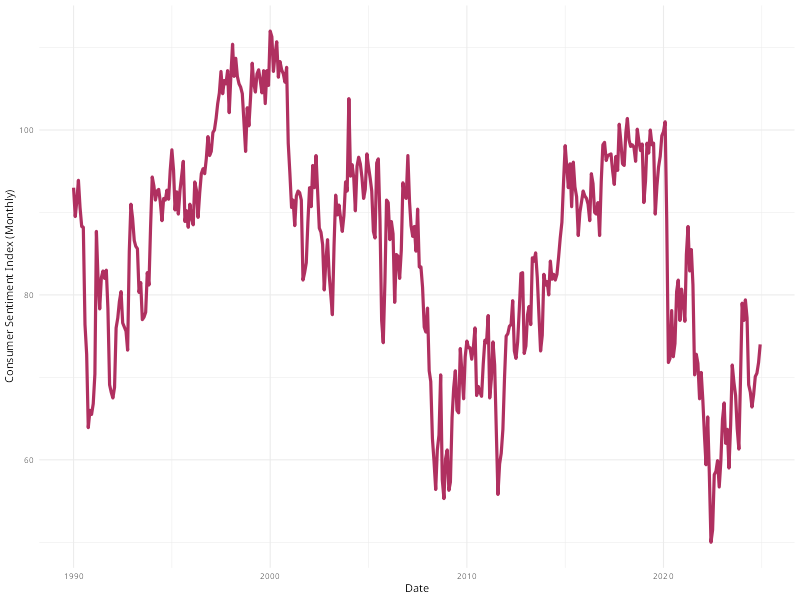

In [3]:
ggplot(economy, mapping = aes(x = date, y = con.sent)) +
    geom_line(color = "maroon", linewidth = 1.5) +
    labs(
        y = "Consumer Sentiment Index (Monthly)",
        x = "Date"
    ) +
    theme_minimal() 

It looks to me like there is positive autocorrelation in this series. That is, if one month is higher, than the next month will also be higher, on average. We can test autocorrelation using `acf()` function.

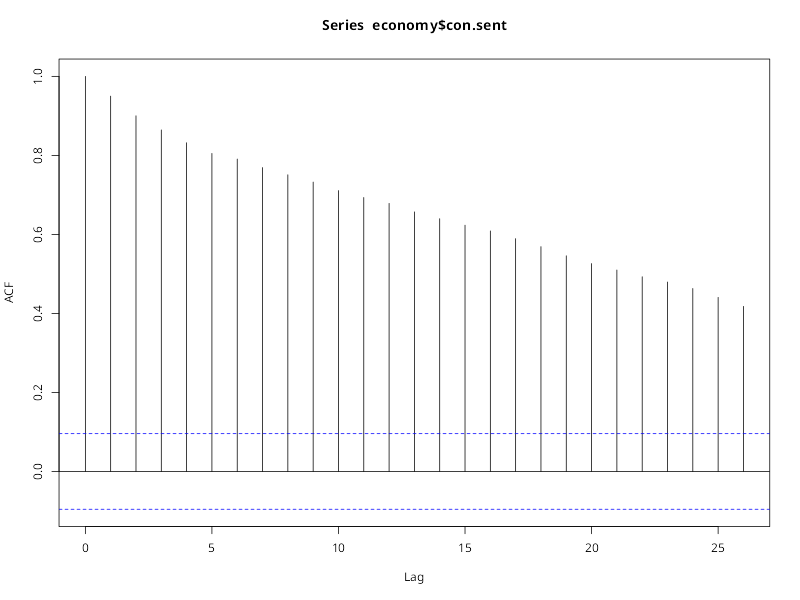

In [4]:
acf(economy$con.sent)

The graph above (known as a *correlogram* shows the correlation between the value of time series at time $_t$ and lags of the series. In this case, there is a positive correlation ($r>.4$) even after 26 months! The regular decrease in the correlation suggests that current values of $y$ are heavily dependent on the previous value of $y$ ($y_{t-1}$). It is *autoregressive*.  

We could, however, transform this measure by examining the *partial autocorrelation function*, which presents the correlation between $y$ and the lagged $y$ presented on the x-axis, after controlling for all the lagged versions  of $y$ at lower values of the lag. So, lag = 3 would show the correlation represented by the regression coefficient between $y$ and $y_{t-3}$ while controlling for $y_{t-1}$ and $y_{t-2}$.  

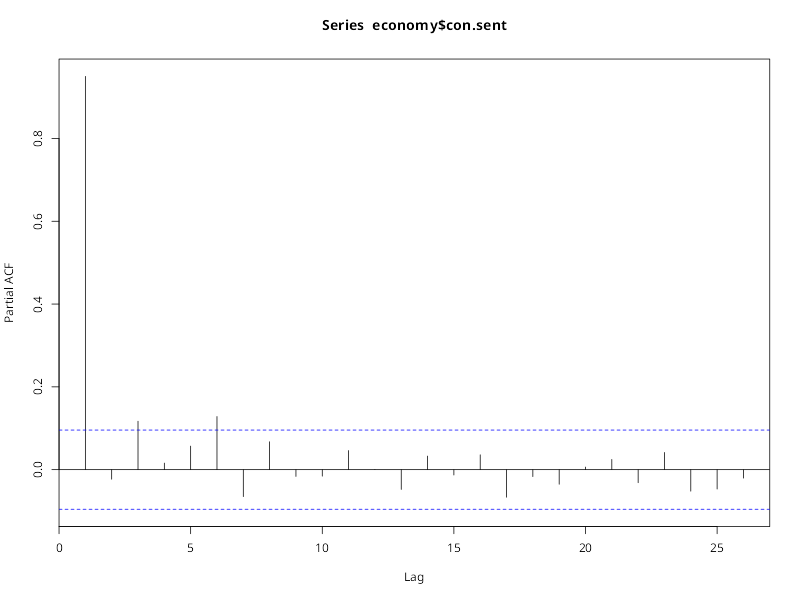

In [5]:
pacf(economy$con.sent)

To continue modeling consumer sentiment over time, we need to process our data more using R's time series functions. This can get quite complex, because different functions expect different stored data (some expect time series data, some expect data frames or vectors), and creating lagged and differenced variables will change the number of observations in a vector. To add to the confusion, some functions are named the same in different packages. There is a `lag()` function in the `stats` package (part of base R) as well as in `dplyr` (part of `tidyverse`). It's confusing. Below I highlight the simpliest way that I know of to model a time series. Note that we'll be using different functions when we model panel time series data later in this activity. 

First, let's tell R the nature of the time series that we have and store our key variables as time series objects in separate vectors, not in a dataframe. 

In [6]:
# ts() function records the vector as a time series
# the start() argument and the frequency argument
# note that we begin the series at the beginning of 1990
# and that the series has 12 time periods per year (months)
# we grab each vector with the df$variable.name notation

con.sent <- ts(economy$con.sent, start(1990, 0), frequency = 12)
un.rate <- ts(economy$un.rate, start(1990, 0), frequency = 12)

# check to make sure the vector looks the way we want. 
# notice that R knows we have monthly data
print(con.sent)

     Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
1   93.0  89.5  91.3  93.9  90.6  88.3  88.2  76.4  72.8  63.9  66.0  65.5
2   66.8  70.4  87.7  81.8  78.3  82.1  82.9  82.0  83.0  78.3  69.1  68.2
3   67.5  68.8  76.0  77.2  79.2  80.4  76.6  76.1  75.6  73.3  85.3  91.0
4   89.3  86.6  85.9  85.6  80.3  81.5  77.0  77.3  77.9  82.7  81.2  88.2
5   94.3  93.2  91.5  92.6  92.8  91.2  89.0  91.7  91.5  92.7  91.6  95.1
6   97.6  95.1  90.3  92.5  89.8  92.7  94.4  96.2  88.9  90.2  88.2  91.0
7   89.3  88.5  93.7  92.7  89.4  92.4  94.7  95.3  94.7  96.5  99.2  96.9
8   97.4  99.7 100.0 101.4 103.2 104.5 107.1 104.4 106.0 105.6 107.2 102.1
9  106.6 110.4 106.5 108.7 106.5 105.6 105.2 104.4 100.9  97.4 102.7 100.5
10 103.9 108.1 105.7 104.6 106.8 107.3 106.0 104.5 107.2 103.2 107.2 105.4
11 112.0 111.3 107.1 109.2 110.7 106.4 108.3 107.3 106.8 105.8 107.6  98.4
12  94.7  90.6  91.5  88.4  92.0  92.6  92.4  91.5  81.8  82.7  83.9  88.8
13  93.0  90.7  95.7  93.

Now that we have our two central variables stored as separate vectors and recognized as time series data, we can create differenced and lagged variables that we can use for analysis. I think it is easiest to make these variables and then use your created data rather than using the difference and lag functions directly inside the model.  

In [ ]:
# note the lag() function.
# 1 means the previous time period, 2 means two time
# periods in the past.
l.con.sent <- stats::lag(con.sent, 1)
l2.con.sent <- stats::lag(con.sent, 2)
d.con.sent <- con.sent - stats::lag(con.sent, 1)
ld.con.sent <- stats::lag(d.con.sent, 1)
l.un.rate <- stats::lag(un.rate, 1)
l2.un.rate <- stats::lag(un.rate, 2)
d.un.rate <- un.rate - stats::lag(un.rate, 1)
ld.un.rate <- stats::lag(d.un.rate, 1)


If you check your enironment window, you should see several new vectors called *l.con.sent*, *l2.con.sent* and the like. *l* is being used to describe a lagged value, while *d* vectors are differenced. 

Now we have 8 new vectors, all coded as time series. But the time periods don't all line up, because some are differenced and some have lags. Differencing and lagging will lead to dropped data. We can us the `ts.intserect` function to align our vectors to the correct time periods and then store as a data frame for analysis.

In [9]:
economy2 <- ts.intersect(con.sent, l.con.sent, l2.con.sent, 
                        d.con.sent, ld.con.sent, 
                        un.rate, l.un.rate, l2.un.rate, 
                        d.un.rate, ld.un.rate,
                        dframe = TRUE)

# check to make sure all the differencing and lagging works as you want it to!
head(economy2)

  con.sent l.con.sent l2.con.sent d.con.sent ld.con.sent un.rate l.un.rate
1     93.0       89.5        91.3        3.5        -1.8     5.4       5.3
2     89.5       91.3        93.9       -1.8        -2.6     5.3       5.2
3     91.3       93.9        90.6       -2.6         3.3     5.2       5.4
4     93.9       90.6        88.3        3.3         2.3     5.4       5.4
5     90.6       88.3        88.2        2.3         0.1     5.4       5.2
6     88.3       88.2        76.4        0.1        11.8     5.2       5.5
  l2.un.rate d.un.rate ld.un.rate
1        5.2       0.1        0.1
2        5.4       0.1       -0.2
3        5.4      -0.2        0.0
4        5.2       0.0        0.2
5        5.5       0.2       -0.3
6        5.7      -0.3       -0.2

## Autoregressive (AR) Models

$AR(\rho)$ models model a time series as a function of $\rho$ lags of the series and random error. The partial autocorrelation function above suggests that the simplest AR model, AR(1), might fit our series well, since after controlling for $y_{t-1}$, there is rarely a significant relationship between the series and higher-order lags. Let's run the AR model.


In [10]:
# we can estimate using OLS. Check out ar.ols() for fitting a more general ar(p) model

ar1 <- lm(con.sent ~ l.con.sent, data = economy2)
summary(ar1)

ar2 <- lm(con.sent ~ l.con.sent + l2.con.sent, data = economy2)
summary(ar2)


Call:
lm(formula = con.sent ~ l.con.sent + l2.con.sent, data = economy2)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.3587  -2.5258   0.0189   2.3554  16.5805 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.37253    1.32105   3.310  0.00101 ** 
l.con.sent   0.97204    0.04909  19.799  < 2e-16 ***
l2.con.sent -0.02276    0.04906  -0.464  0.64301    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.129 on 415 degrees of freedom
Multiple R-squared:  0.9047,	Adjusted R-squared:  0.9043 
F-statistic:  1971 on 2 and 415 DF,  p-value: < 2.2e-16


## Autoregressive Distriuted Lag (ADL) Models

Autoregressive distributed lag models include predictors in the autoregressive lag framework.

In [ ]:
adl <- lm(con.sent ~ l.un.rate, data = economy2)
summary(adl)


Call:
lm(formula = con.sent ~ l.un.rate, data = economy2)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.466  -4.419   2.425   7.408  33.233 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 103.8013     2.0232  51.304   <2e-16 ***
l.un.rate    -3.2388     0.3383  -9.574   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.09 on 416 degrees of freedom
Multiple R-squared:  0.1806,	Adjusted R-squared:  0.1786 
F-statistic: 91.66 on 1 and 416 DF,  p-value: < 2.2e-16


In [ ]:
adl2 <- lm(con.sent ~ l.un.rate + l.con.sent, data = economy2)
summary(adl2)



Call:
lm(formula = con.sent ~ l.un.rate + l.con.sent, data = economy2)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.9753  -2.5106   0.1388   2.2566  18.3121 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.44758    1.85978   3.467 0.000582 ***
l.un.rate   -0.20744    0.12709  -1.632 0.103391    
l.con.sent   0.93886    0.01666  56.353  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.117 on 415 degrees of freedom
Multiple R-squared:  0.9053,	Adjusted R-squared:  0.9048 
F-statistic:  1983 on 2 and 415 DF,  p-value: < 2.2e-16


The Augmented Dickey-Fuller test is evaluates whether your time series is stationary. The null hypothesis is non-stationarity. The code below runs the test twice; the first test uses the raw series, the second uses the differenced series. 

In [ ]:
adf.test(economy2$con.sent)


	Augmented Dickey-Fuller Test

data:  economy2$con.sent
Dickey-Fuller = -2.314, Lag order = 7, p-value = 0.4448
alternative hypothesis: stationary


In [ ]:
adf.test(economy2$d.con.sent)

Warning message:
In adf.test(economy2$d.con.sent) : p-value smaller than printed p-value



	Augmented Dickey-Fuller Test

data:  economy2$d.con.sent
Dickey-Fuller = -8.5333, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


Interpret both tests in a Markdown text chunk. Which series should we be using in our analysis? 

We can first-difference this model by regressing the change (difference) in consumer sentiment on a number of candidate specifications: 

1. lagged unemployment rate; 
1. differenced unemployment rate;
2. difference unemployment rate and the lagged differenced unemployment rate.

In [ ]:

fd <- lm(d.con.sent ~ l.un.rate, data = economy2)
fd1 <- lm(d.con.sent ~ d.un.rate, data = economy2)
fd2 <- lm(d.con.sent ~ d.un.rate + ld.un.rate, data = economy2)

Create a regression table using `modelsummary()` that presents `fd`, `fd1`, and `fd2` model results. The table should have stars to denote p-values next to model coefficients and include standard errors in parentheses below the coefficients. Include a title for the table in the code chunk in Quarto that will show up in your pdf file when you render the document. Check out [this page](https://quarto.org/docs/authoring/tables.html#computations) for details on how to do this. 

Then, using Markdown, interpret your regression results from the three models. 

## Panel Data 

As policy researchers, we often deal with panel data. That is, we have data over time on multiple units. And we are interested in the over-time dynamics and the cross-sectional relationships across units. 

In this exercise, let's examine data from the Organization for Economic Coordination and Development (OECD). The outcome variable is economic productivity (GDP per hour)

Let's use a couple of `for` loops to get and process the data. Loops are nice ways to simplify your code: instead of copy and pasteing multiple lines of code, you can loop over a set of object and plug those objects into the lines of code. The first loop below imports the data using `paste0()` (function that allows you to create character strings without a separator character) and `assign()` (can provide a name for an object). The second loop uses `get()` and `assign()` to take the dataframes, select just the needed variables, rename the core data, and store back in the dataframe.

In [16]:
# import the csv files from GitHub - each variable is stored in its own csv file

# loop over three datasets/variables
for(i in c("gdp_perhour", "life_exp", "ppp_spend")){
        file <- paste0("https://raw.githubusercontent.com/bowendc/512_labs/refs/heads/main/",
                        i, "_2002-2020.csv") # store url to `file`
        df <- read_csv(file) # call our dataframe `df`
        assign(i, df)        # apply the name stored in i to df
}

# quick processing of the education spending data to include just 
# higher ed spending
ppp_spend <- ppp_spend |> filter(`Education level` == "Tertiary education")

# loop over dataframes to keep only necessary vars and rename main
# variable same as name of dataframe
for(i in c("gdp_perhour", "life_exp", "ppp_spend")){
  df <- get(i)
  df <- df |> 
  select(REF_AREA, `Reference area`, TIME_PERIOD, OBS_VALUE) |>
  rename(!!i := OBS_VALUE)    # to dynamically change a variable name in 
  assign(i, df)               # rename or mutate, use !! in front of the looped
}                             # object and use := instead of =

Rows: 866 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (26): STRUCTURE, STRUCTURE_ID, STRUCTURE_NAME, ACTION, REF_AREA, Referen...
dbl  (5): TIME_PERIOD, OBS_VALUE, UNIT_MULT, BASE_PER, DECIMALS
lgl  (3): Time period, Observation value, Base period

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 929 Columns: 43
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (31): STRUCTURE, STRUCTURE_ID, STRUCTURE_NAME, REF_AREA, Reference area,...
dbl  (2): TIME_PERIOD, OBS_VALUE
lgl (10): Time period, Observation value, DECIMALS, Decimals, OBS_STATUS2, O...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2181 Columns: 32
── Column specification ────────────────

Now we have three separate dataframes, each containing one of our variables of interest. Let's combine them into one dataframe for analysis. Since we want observations to remain in the dataset if they are in ANY of the three dataframes, we'll use `full_join()`.

In [17]:
# combine dataframes into one. 
# full_join() keeps observations without matches in both datasets
# REF_AREA is the country code and TIME_PERIOD is the year.
# both are needed to match the data together.
prod <- full_join(gdp_perhour, life_exp, by = join_by(REF_AREA, TIME_PERIOD))

# we run it again to join in ppp
prod <- full_join(prod, ppp_spend, by = join_by(REF_AREA, TIME_PERIOD))

# let's check to make sure everythign worked: 
head(prod)

# A tibble: 6 × 8
  REF_AREA `Reference area.x` TIME_PERIOD gdp_perhour `Reference area.y`
  <chr>    <chr>                    <dbl>       <dbl> <chr>             
1 ISL      Iceland                   2002        45.4 Iceland           
2 ISL      Iceland                   2003        46.9 Iceland           
3 ISL      Iceland                   2004        50.1 Iceland           
4 ISL      Iceland                   2005        51.6 Iceland           
5 ISL      Iceland                   2006        52.9 Iceland           
6 ISL      Iceland                   2007        56.1 Iceland           
# ℹ 3 more variables: life_exp <dbl>, `Reference area` <chr>, ppp_spend <dbl>

Here we can conduct a number of different types of regression models using `plm()` (panel linear models). We can add fixed effects (FE) by country using `effect = c("individual")` and `model = "within"`. If we set `model = "pooling"`, we get normal OLS estimates.

Also of note: `plm()` has a more intuitive lag and differencing notation, which allows us to easily use the `lag()` and `diff()` functions inside of a `plm()` call.

In [18]:

# OLS
m1 <- plm(gdp_perhour ~ lag(life_exp) + lag(ppp_spend), data = prod, 
                      model = "pooling",
                      index = c("REF_AREA", "TIME_PERIOD"))
# FE by country
m2 <- plm(gdp_perhour ~ lag(life_exp) + lag(ppp_spend), data = prod, 
                      model = "within",
                      index = c("REF_AREA", "TIME_PERIOD"),
                      effect = c("individual"))

# FE by country, includes lagged outcome var
m2b <- plm(gdp_perhour ~ lag(life_exp) + lag(ppp_spend) + lag(gdp_perhour), data = prod, 
                      model = "within",
                      index = c("REF_AREA", "TIME_PERIOD"),
                      effect = c("individual"))

# TWFE: FE by country and time period
m3 <- plm(gdp_perhour ~ lag(life_exp) + lag(ppp_spend), data = prod, 
                      model = "within",
                      index = c("REF_AREA", "TIME_PERIOD"),
                      effect = c("twoway"))

# TWFE, includes lagged outcome
m3b <- plm(gdp_perhour ~ lag(life_exp) + lag(ppp_spend) + lag(gdp_perhour), data = prod, 
                      model = "within",
                      index = c("REF_AREA", "TIME_PERIOD"),
                      effect = c("twoway"))

modelsummary(list(m1, m2, m2b, m3, m3b))


,(1),(2),(3),(4),(5)
(Intercept),-127.432,,,,
,(15.591),,,,
lag(life_exp),1.942,2.173,0.141,1.793,0.135
,(0.203),(0.205),(0.128),(0.313),(0.174)
lag(ppp_spend),0.002,0.000,-0.000,0.000,-0.000
,(0.000),(0.000),(0.000),(0.000),(0.000)
lag(gdp_perhour),,,1.055,,1.061
,,,(0.034),,(0.034)
Num.Obs.,438,438,438,438,438
R2,0.673,0.486,0.851,0.093,0.747


We can use the Breusch-Godfrey/Wooldridge test to check for serial correlation. This time the null hypothesis is *no serial correlation*. 

In [21]:
#Breusch/Godfrey test for serial correlation
pbgtest(m3)
pbgtest(m3b)


	Breusch-Godfrey/Wooldridge test for serial correlation in panel models

data:  gdp_perhour ~ lag(life_exp) + lag(ppp_spend) + lag(gdp_perhour)
chisq = 15.271, df = 1, p-value = 9.311e-05
alternative hypothesis: serial correlation in idiosyncratic errors


Do our models suffer from serially correlated errors? Interpret the test in Markdown block.

In [23]:
# we can use plm with model = "fd" to run a first difference regression. This will 
# difference the outcome variable for us.
# I'm also nesting diff() inside of lag() to get change measures of the 
# predictor variables, lagged a year. 
m4 <- plm(gdp_perhour ~ lag(diff(life_exp)) + lag(diff(ppp_spend)) , data = prod, 
                      model = "fd",
                      index = c("REF_AREA", "TIME_PERIOD"))

pbgtest(m4)
summary(m4)

Oneway (individual) effect First-Difference Model

Call:
plm(formula = gdp_perhour ~ lag(diff(life_exp)) + lag(diff(ppp_spend)), 
    data = prod, model = "fd", index = c("REF_AREA", "TIME_PERIOD"))

Unbalanced Panel: n = 40, T = 3-11, N = 364
Observations used in estimation: 324

Residuals:
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-3.74215 -0.61738 -0.23432  0.26049 17.49178 

Coefficients:
                       Estimate Std. Error t-value  Pr(>|t|)    
(Intercept)          7.7441e-01 9.2217e-02  8.3977 1.484e-15 ***
lag(diff(life_exp))  3.1320e-01 1.8877e-01  1.6592   0.09805 .  
lag(diff(ppp_spend)) 2.8558e-05 5.3537e-05  0.5334   0.59411    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    891.81
Residual Sum of Squares: 883.7
R-Squared:      0.0090942
Adj. R-Squared: 0.0029204
F-statistic: 1.47302 on 2 and 321 DF, p-value: 0.23078

Interpret the results of Model 5 in some Markdown text. Is a lagged change in life expectancy associated with increases in economic productivity? If so, how much? Does our first difference model have a serial correlation problem? 